observable variables I use are: the underlying asset returns, the Ted Spread, the 10 year - 2 year constant maturity spread, and the 10 year - 3 month constant maturity spread.

In [1]:
import pandas as pd
import sklearn.mixture as mix
from pandas_datareader import data as pdr
import fix_yahoo_finance
fix_yahoo_finance.pdr_override()
import numpy as np
import quandl
from tqdm.autonotebook import tqdm
tqdm.pandas()
import scipy.stats as scs

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

In [21]:
import seaborn as sns
import missingno as msno

In [4]:
# get fed data
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

In [5]:
start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (pd.DataFrame(pdr.get_data_yahoo(mkt,  start, end)['Adj Close']
       .rename(columns={mkt:mkt})))

[*********************100%***********************]  1 of 1 downloaded


In [6]:
MKT.columns = ['SPY']

In [7]:
MKT['sret'] = np.log(MKT['SPY']/MKT['SPY'].shift(1))

In [8]:
MKT.dropna(inplace=True)

In [9]:
MKT.head()

,SPY,sret
Date,,
2002-01-03,83.39,0.011215
2002-01-04,83.95,0.006693
2002-01-07,83.36,-0.007053
2002-01-08,83.16,-0.002402
2002-01-09,82.49,-0.008089


In [10]:
f2_data = quandl.get("FRED/T10Y2Y", start_date= start, end_date= end).rename(columns={'Value':f2})

In [11]:
f1_data = quandl.get("FRED/"+f1, start_date = start, end_date = end).rename(columns={'Value':f1})

In [12]:
f3_data = quandl.get("FRED/"+f3, start_date = start, end_date = end).rename(columns={'Value':f3})

In [13]:
f1_data.head()

,TEDRATE
Date,
2002-01-02,0.15
2002-01-03,0.18
2002-01-04,0.18
2002-01-07,0.21
2002-01-08,0.19


In [19]:
dfs = [MKT, f1_data, f2_data, f3_data]
import functools
df_merged = functools.reduce(lambda left, right:pd.merge(left,right,on=['Date'],
                                              how='inner'),dfs)

In [22]:
df_merged.dropna(inplace=True)

In [23]:
df_merged.head()

,SPY,sret,TEDRATE,T10Y2Y,T10Y3M
Date,,,,,
2002-01-03,83.39,0.011215,0.18,1.97,3.43
2002-01-04,83.95,0.006693,0.18,1.99,3.46
2002-01-07,83.36,-0.007053,0.21,2.01,3.41
2002-01-08,83.16,-0.002402,0.19,2.03,3.42
2002-01-09,82.49,-0.008089,0.19,2.07,3.42


In [24]:
X = df_merged.iloc[:,1:].values


In [25]:
model = mix.GaussianMixture(n_components=3,
                           covariance_type='full',
                           n_init=100,
                           random_state=42).fit(X)

In [26]:
hidden_states = model.predict(X)

In [36]:
print("Means and vars of each hidden state")
print('\n')
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state


0th hidden state
mean =  [5.64146378e-04 2.64734383e-01 1.77897584e+00 2.31517374e+00]
var =  [7.59222142e-05 8.94038586e-03 4.40842724e-01 5.62074649e-01]

1th hidden state
mean =  [0.00079091 0.4279339  0.12066762 0.2753255 ]
var =  [4.68857659e-05 1.77751712e-02 2.86962328e-02 2.41163876e-01]

2th hidden state
mean =  [-1.50281109e-03  9.75924204e-01  1.60462773e+00  2.25746772e+00]
var =  [4.37329696e-04 5.48742203e-01 3.15925642e-01 9.03273478e-01]



In [28]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


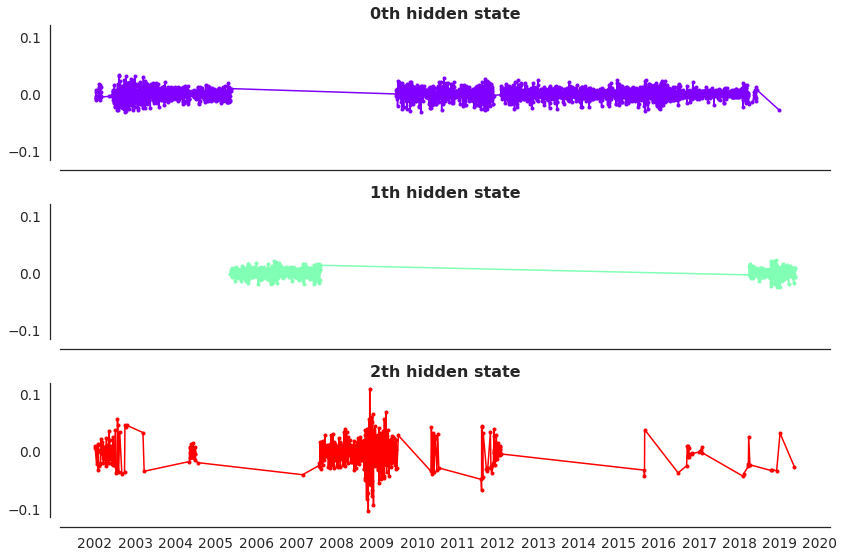

In [31]:
fig, axs = plt.subplots(model.n_components,
                        sharex=True,
                        sharey=True,
                        figsize=(12,8))

colors = cm.rainbow(np.linspace(0,1,model.n_components))

col = 'sret'
select = df_merged.copy()
ft_cols = [f1, f2, f3, 'sret']

for i, (ax, color) in enumerate(zip(axs, colors)):
    
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                select[col].values[mask],
                '.-', c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16,fontweight="demi")
    
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    
    sns.despine(offset=10)

plt.tight_layout()

In [40]:
sns.set(font_scale=1.5)
states = pd.DataFrame(
    hidden_states, columns=['states'], index=select.index).join(
        select, how='inner').assign(mkt_cret=select.sret.cumsum()).reset_index(
            drop=False).rename(columns={'index': 'Date'})

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5, 0.98, 'Historical SPY Regimes')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


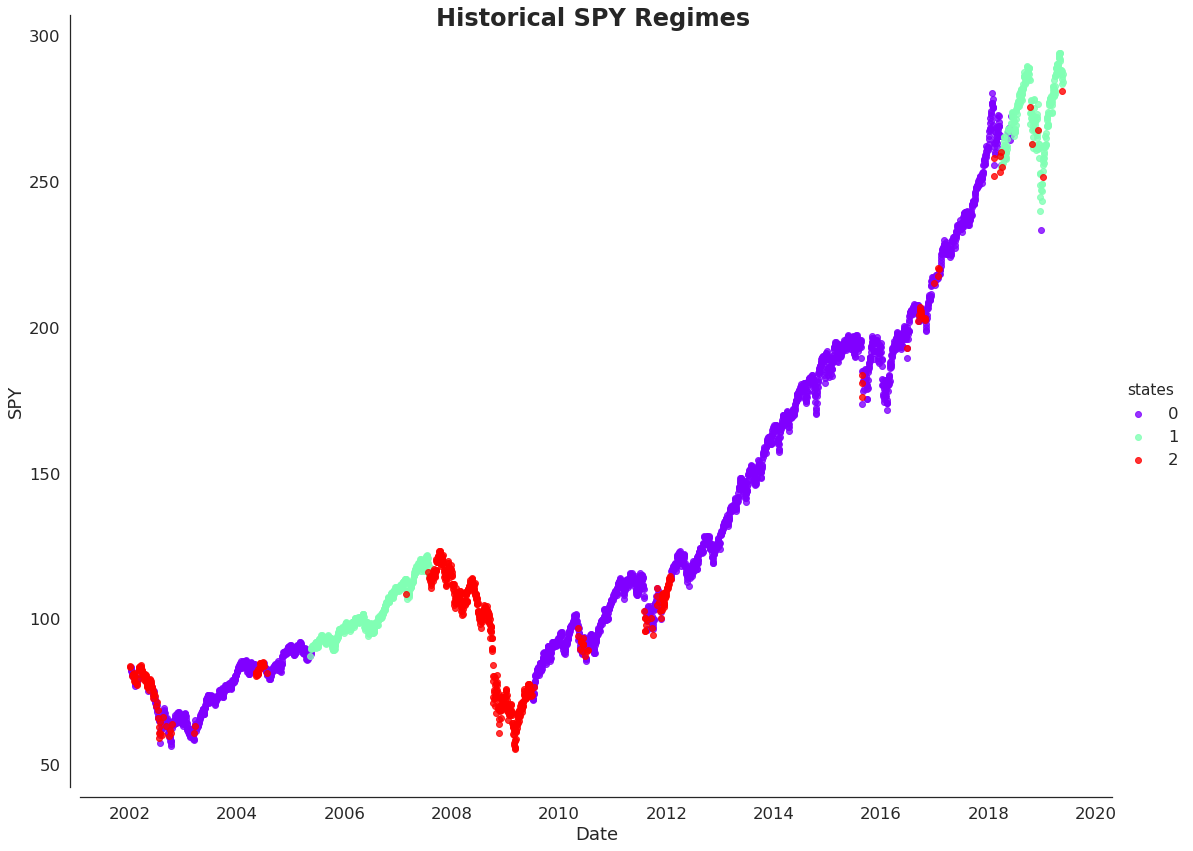

In [43]:
sns.set_style('white', style_kwds)
order = [0, 1, 2]

fg = sns.FacetGrid(
    data=states,
    hue='states',
    hue_order=order,
    palette=colors,
    aspect=1.31,
    size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')